# Enunciado do trabalho 2 - individual

Com este trabalho pretende-se que os alunos explorem GANs e/ou Autoencoders num problema à escolha do aluno. Há imensos datasets disponíveis para treinar este tipo de redes.

O objectivo principal é explorar as funções de erro, por exemplo na linha do que foi feito na Pix2Pix ou Cycle GAN, e/ou explorar manipulações e combinações de datasets.

O relatório deve ser sucinto, podendo estar incluído no próprio notebook, e deverá conter a descrição da estratégia definida pelos alunos assim como uma discussão/comparação dos resultados obtidos. No caso da comparação esta deverá ser feita com base em resultados publicados por terceiros.

Submissão via BB.

Data final de submissão: 18 de Junho

https://medium.com/@chloelim608/converting-landscapes-into-minecraft-images-with-cyclegan-dd12c284659b

In [117]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
from tqdm import tqdm

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

import kagglehub

import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Componentes do Modelo

https://github.com/henry32144/cyclegan-notebook/blob/master/pytorch_cycle_gan.ipynb

# Download datasets

In [118]:
landscape_dataset = kagglehub.dataset_download(
    "utkarshsaxenadn/landscape-recognition-image-dataset-12k-images"
)
minecraft_dataset = kagglehub.dataset_download(
    "pr1m3r/minecraft-dimensions-screenshots"
)

print(landscape_dataset)
print(minecraft_dataset)

C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3


# Carregar imagens

In [119]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# Define transforms
transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

landscape_dataset_path = (
    pathlib.Path(landscape_dataset)
    / "Landscape Classification"
    / "Landscape Classification"
    / "Training Data"
)

minecraft_dataset_path = (
    pathlib.Path(minecraft_dataset) / "data" / "nether_comparison_data" / "overworld_sc"
)

print(landscape_dataset_path)
print(minecraft_dataset_path)

# Get image paths
landscape_images = list(landscape_dataset_path.glob("**/*.jpeg"))
minecraft_images = list(minecraft_dataset_path.glob("**/*.png"))

print(f"Found {len(landscape_images)} landscape images")
print(f"Found {len(minecraft_images)} minecraft images")

# Create datasets
landscape_pytorch_dataset = ImageDataset(landscape_images, transform=transform)
minecraft_pytorch_dataset = ImageDataset(minecraft_images, transform=transform)

# Create data loaders
batch_size = 8
landscape_loader = torch.utils.data.DataLoader(
    landscape_pytorch_dataset, batch_size=batch_size, shuffle=True
)
minecraft_loader = torch.utils.data.DataLoader(
    minecraft_pytorch_dataset, batch_size=batch_size, shuffle=True
)

print(
    f"Landscape dataset: {len(landscape_pytorch_dataset)} images, {len(landscape_loader)} batches"
)
print(
    f"Minecraft dataset: {len(minecraft_pytorch_dataset)} images, {len(minecraft_loader)} batches"
)


C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3\Landscape Classification\Landscape Classification\Training Data
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3\data\nether_comparison_data\overworld_sc
Found 10000 landscape images
Found 300 minecraft images
Landscape dataset: 10000 images, 1250 batches
Minecraft dataset: 300 images, 38 batches


Sample landscape images:


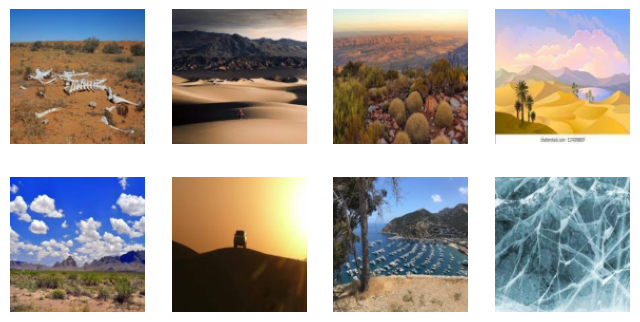

<Figure size 640x480 with 0 Axes>

Sample minecraft images:


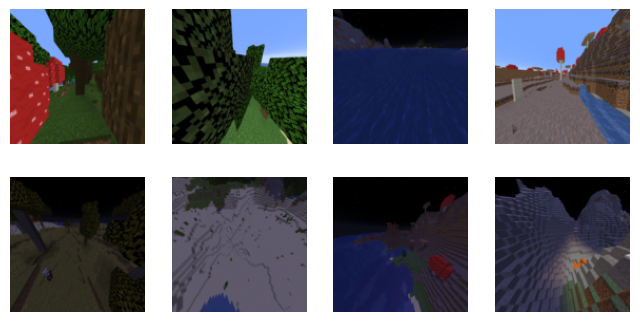

<Figure size 640x480 with 0 Axes>

In [120]:
landscape_batch = next(iter(landscape_loader))
minecraft_batch = next(iter(minecraft_loader))


def show_images(rows, cols, images):
    width = 2 * rows
    height = 2 * cols

    f, axes = plt.subplots(rows, cols, figsize=(height, width))
    fig = plt.figure()

    for a in range(rows * cols):
        axes.ravel()[a].imshow(
            np.clip(np.transpose(images[a].numpy(), (1, 2, 0)) * 0.5 + 0.5, 0, 1),
            cmap=plt.cm.gray,
        )
        axes.ravel()[a].axis("off")
    fig.tight_layout()
    plt.show()


print("Sample landscape images:")
show_images(2, 4, landscape_batch[:8])

print("Sample minecraft images:")
show_images(2, 4, minecraft_batch[:8])

# Generator (CycleGAN)
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [121]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

# Discriminator

In [122]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=stride,
            padding=1,
            bias=True,
            padding_mode="reflect",
        )
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return self.model(x)

# Training

In [123]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model_states=None):
        if self.best_loss is None:
            self.best_loss = val_loss
            if model_states is not None:
                self.best_weights = self._deep_copy_model_states(model_states)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model_states is not None:
                self.best_weights = self._deep_copy_model_states(model_states)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def _deep_copy_model_states(self, model_states):
        """Deep copy nested model state dictionaries."""
        return {
            model_name: {param_name: tensor.clone() for param_name, tensor in state_dict.items()}
            for model_name, state_dict in model_states.items()
        }

    def restore_weights(self):
        """Return the best weights if available."""
        return self.best_weights if self.best_weights is not None else None


In [124]:
# Training Configuration
DEVICE = device
LAMBDA_CYCLE = 10.0  # weight for cycle consistency loss
LEARNING_RATE = 2e-4
BETAS = (0.5, 0.999)  # Adam optimizer betas
MAX_EPOCHS = 200

# Early Stopping Configuration
EARLY_STOPPING_PATIENCE = 10  # Number of epochs to wait for improvement
EARLY_STOPPING_MIN_DELTA = 0.001  # Minimum change to qualify as improvement
EARLY_STOPPING_MONITOR = 'cycle_loss'  # Monitor cycle consistency loss

# Create outputs directory if it doesn't exist
os.makedirs("outputs", exist_ok=True)


In [125]:
def train_fn(
    disc_minecraft,
    disc_landscape,
    gen_landscape,
    gen_minecraft,
    loader,
    opt_disc,
    opt_gen,
    l1,
    mse,
    d_scaler,
    g_scaler,
    epoch,
):
    """
    Adapted training function for Minecraft-GAN:
    - disc_minecraft: Discriminator for Minecraft domain
    - disc_landscape: Discriminator for Landscape domain
    - gen_landscape: Generator that converts Minecraft -> Landscape
    - gen_minecraft: Generator that converts Landscape -> Minecraft
    
    Returns:
        dict: Dictionary containing average losses for the epoch
    """
    minecraft_reals = 0
    minecraft_fakes = 0
    total_d_loss = 0
    total_g_loss = 0
    total_cycle_loss = 0
    num_batches = 0
    
    loop = tqdm(loader, leave=True)

    for idx, (landscape, minecraft) in enumerate(loop):
        landscape = landscape.to(DEVICE)
        minecraft = minecraft.to(DEVICE)

        # Train discriminators for Minecraft and Landscape domains
        with torch.autocast(device_type="cuda"):
            # Generate fake minecraft from landscape
            fake_minecraft = gen_minecraft(landscape)
            D_minecraft_real = disc_minecraft(minecraft)
            D_minecraft_fake = disc_minecraft(fake_minecraft.detach())
            minecraft_reals += D_minecraft_real.mean().item()
            minecraft_fakes += D_minecraft_fake.mean().item()
            D_minecraft_real_loss = mse(
                D_minecraft_real, torch.ones_like(D_minecraft_real)
            )
            D_minecraft_fake_loss = mse(
                D_minecraft_fake, torch.zeros_like(D_minecraft_fake)
            )
            D_minecraft_loss = D_minecraft_real_loss + D_minecraft_fake_loss

            # Generate fake landscape from minecraft
            fake_landscape = gen_landscape(minecraft)
            D_landscape_real = disc_landscape(landscape)
            D_landscape_fake = disc_landscape(fake_landscape.detach())
            D_landscape_real_loss = mse(
                D_landscape_real, torch.ones_like(D_landscape_real)
            )
            D_landscape_fake_loss = mse(
                D_landscape_fake, torch.zeros_like(D_landscape_fake)
            )
            D_landscape_loss = D_landscape_real_loss + D_landscape_fake_loss

            # Total discriminator loss
            D_loss = (D_minecraft_loss + D_landscape_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators for both domains
        with torch.autocast(device_type="cuda"):
            # Adversarial losses for generators
            D_minecraft_fake = disc_minecraft(fake_minecraft)
            D_landscape_fake = disc_landscape(fake_landscape)
            loss_G_minecraft = mse(D_minecraft_fake, torch.ones_like(D_minecraft_fake))
            loss_G_landscape = mse(D_landscape_fake, torch.ones_like(D_landscape_fake))

            # Cycle consistency losses
            cycle_landscape = gen_landscape(fake_minecraft)
            cycle_minecraft = gen_minecraft(fake_landscape)
            cycle_landscape_loss = l1(landscape, cycle_landscape)
            cycle_minecraft_loss = l1(minecraft, cycle_minecraft)

            # Total cycle loss
            cycle_loss = cycle_landscape_loss + cycle_minecraft_loss

            # Total generator loss
            G_loss = (
                loss_G_landscape
                + loss_G_minecraft
                + cycle_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Accumulate losses for monitoring
        total_d_loss += D_loss.item()
        total_g_loss += G_loss.item()
        total_cycle_loss += cycle_loss.item()
        num_batches += 1

        if idx == 0:
            save_image(fake_minecraft * 0.5 + 0.5, f"outputs/minecraft_{epoch}_{idx}.png")
            save_image(fake_landscape * 0.5 + 0.5, f"outputs/landscape_{epoch}_{idx}.png")

        loop.set_postfix(
            minecraft_real=minecraft_reals / (idx + 1),
            minecraft_fake=minecraft_fakes / (idx + 1),
            d_loss=total_d_loss / (idx + 1),
            g_loss=total_g_loss / (idx + 1),
            cycle_loss=total_cycle_loss / (idx + 1),
        )
    
    # Return average losses for the epoch
    return {
        'discriminator_loss': total_d_loss / num_batches,
        'generator_loss': total_g_loss / num_batches,
        'cycle_loss': total_cycle_loss / num_batches,
        'minecraft_real_score': minecraft_reals / num_batches,
        'minecraft_fake_score': minecraft_fakes / num_batches,
    }


In [126]:
def create_combined_loader(landscape_loader, minecraft_loader, max_batches=None):
    """
    Create a combined data loader that yields pairs of (landscape, minecraft) batches.
    Since the datasets have different sizes, we'll cycle through the smaller one.
    """
    landscape_iter = iter(landscape_loader)
    minecraft_iter = iter(minecraft_loader)
    
    batches_processed = 0
    
    while True:
        try:
            landscape_batch = next(landscape_iter)
        except StopIteration:
            landscape_iter = iter(landscape_loader)
            landscape_batch = next(landscape_iter)
            
        try:
            minecraft_batch = next(minecraft_iter)
        except StopIteration:
            minecraft_iter = iter(minecraft_loader)
            minecraft_batch = next(minecraft_iter)
            
        # Ensure both batches have the same size
        min_size = min(landscape_batch.size(0), minecraft_batch.size(0))
        landscape_batch = landscape_batch[:min_size]
        minecraft_batch = minecraft_batch[:min_size]
        
        yield landscape_batch, minecraft_batch
        
        batches_processed += 1
        if max_batches and batches_processed >= max_batches:
            break


In [127]:
# Initialize models
disc_minecraft = Discriminator(in_channels=3).to(DEVICE)
disc_landscape = Discriminator(in_channels=3).to(DEVICE)
gen_landscape = Generator(img_channels=3, num_features=64).to(DEVICE)  # Minecraft -> Landscape
gen_minecraft = Generator(img_channels=3, num_features=64).to(DEVICE)  # Landscape -> Minecraft

# Initialize optimizers
opt_disc = optim.Adam(
    list(disc_minecraft.parameters()) + list(disc_landscape.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)
opt_gen = optim.Adam(
    list(gen_landscape.parameters()) + list(gen_minecraft.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)

# Loss functions
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Gradient scalers for mixed precision training
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

print("Models and optimizers initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in gen_minecraft.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc_minecraft.parameters()):,}")


Models and optimizers initialized successfully!
Generator parameters: 7,837,699
Discriminator parameters: 2,764,737


In [128]:
# Initialize early stopping
early_stopping = EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE, 
    min_delta=EARLY_STOPPING_MIN_DELTA,
    restore_best_weights=True
)

# Main training loop
print("Starting training...")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"Monitoring: {EARLY_STOPPING_MONITOR} with min_delta: {EARLY_STOPPING_MIN_DELTA}")

max_possible_batches = max(len(landscape_loader), len(minecraft_loader))
batches_per_epoch = min(100, max_possible_batches)  # Limit to 100 batches per epoch
print(f"Maximum possible batches: {max_possible_batches}")
print(f"Reduced batches per epoch: {batches_per_epoch}")

# Training history for plotting
training_history = {
    'epoch': [],
    'discriminator_loss': [],
    'generator_loss': [],
    'cycle_loss': [],
    'minecraft_real_score': [],
    'minecraft_fake_score': []
}

for epoch in range(MAX_EPOCHS):
    print(f"\n=== Epoch {epoch + 1}/{MAX_EPOCHS} ===")

    # Create combined data loader for this epoch
    combined_loader = create_combined_loader(
        landscape_loader, minecraft_loader, max_batches=batches_per_epoch
    )

    # Train for one epoch
    epoch_losses = train_fn(
        disc_minecraft=disc_minecraft,
        disc_landscape=disc_landscape,
        gen_landscape=gen_landscape,
        gen_minecraft=gen_minecraft,
        loader=combined_loader,
        opt_disc=opt_disc,
        opt_gen=opt_gen,
        l1=L1,
        mse=mse,
        d_scaler=d_scaler,
        g_scaler=g_scaler,
        epoch=epoch
    )
    
    # Store training history
    training_history['epoch'].append(epoch + 1)
    for key, value in epoch_losses.items():
        training_history[key].append(value)
    
    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Discriminator Loss: {epoch_losses['discriminator_loss']:.6f}")
    print(f"  Generator Loss: {epoch_losses['generator_loss']:.6f}")
    print(f"  Cycle Loss: {epoch_losses['cycle_loss']:.6f}")
    
    # Early stopping check
    monitor_loss = epoch_losses[EARLY_STOPPING_MONITOR]
    
    # Get current model states for potential restoration
    model_states = {
        'gen_minecraft': {k: v.cpu() for k, v in gen_minecraft.state_dict().items()},
        'gen_landscape': {k: v.cpu() for k, v in gen_landscape.state_dict().items()},
        'disc_minecraft': {k: v.cpu() for k, v in disc_minecraft.state_dict().items()},
        'disc_landscape': {k: v.cpu() for k, v in disc_landscape.state_dict().items()},
    }
    
    early_stopping(monitor_loss, model_states)
    
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")
        
        # Restore best weights if available
        if early_stopping.restore_best_weights and early_stopping.best_weights is not None:
            print("Restoring best model weights...")
            gen_minecraft.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights['gen_minecraft'].items()})
            gen_landscape.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights['gen_landscape'].items()})
            disc_minecraft.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights['disc_minecraft'].items()})
            disc_landscape.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights['disc_landscape'].items()})
        
        break

    # Save model checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            "gen_minecraft_state_dict": gen_minecraft.state_dict(),
            "gen_landscape_state_dict": gen_landscape.state_dict(),
            "disc_minecraft_state_dict": disc_minecraft.state_dict(),
            "disc_landscape_state_dict": disc_landscape.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict(),
            "epoch": epoch,
            "training_history": training_history,
            "early_stopping_state": {
                'best_loss': early_stopping.best_loss,
                'counter': early_stopping.counter,
                'patience': early_stopping.patience,
            }
        }
        torch.save(checkpoint, f"outputs/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

print("Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['epoch'], training_history['discriminator_loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(training_history['epoch'], training_history['generator_loss'], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(training_history['epoch'], training_history['cycle_loss'], label='Cycle Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cycle Consistency Loss Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal training statistics:")
print(f"Total epochs trained: {len(training_history['epoch'])}")
print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")
if early_stopping.early_stop:
    print(f"Training stopped early due to no improvement for {EARLY_STOPPING_PATIENCE} epochs")


Starting training...
Early stopping patience: 10 epochs
Monitoring: cycle_loss with min_delta: 0.001
Maximum possible batches: 1250
Reduced batches per epoch: 100

=== Epoch 1/200 ===


100it [00:24,  4.11it/s, cycle_loss=0.66, d_loss=0.578, g_loss=7.64, minecraft_fake=0.358, minecraft_real=0.623]


Epoch 1 Summary:
  Discriminator Loss: 0.577558
  Generator Loss: 7.636720
  Cycle Loss: 0.659866

=== Epoch 2/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.532, d_loss=0.405, g_loss=6.43, minecraft_fake=0.304, minecraft_real=0.686]


Epoch 2 Summary:
  Discriminator Loss: 0.404749
  Generator Loss: 6.432691
  Cycle Loss: 0.532458

=== Epoch 3/200 ===


100it [00:23,  4.18it/s, cycle_loss=0.469, d_loss=0.367, g_loss=5.87, minecraft_fake=0.269, minecraft_real=0.725]


Epoch 3 Summary:
  Discriminator Loss: 0.367143
  Generator Loss: 5.865172
  Cycle Loss: 0.469028

=== Epoch 4/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.435, d_loss=0.352, g_loss=5.56, minecraft_fake=0.263, minecraft_real=0.732]


Epoch 4 Summary:
  Discriminator Loss: 0.352295
  Generator Loss: 5.561992
  Cycle Loss: 0.434504

=== Epoch 5/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.433, d_loss=0.34, g_loss=5.6, minecraft_fake=0.241, minecraft_real=0.757] 


Epoch 5 Summary:
  Discriminator Loss: 0.340211
  Generator Loss: 5.603462
  Cycle Loss: 0.432902

=== Epoch 6/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.404, d_loss=0.321, g_loss=5.35, minecraft_fake=0.23, minecraft_real=0.769]


Epoch 6 Summary:
  Discriminator Loss: 0.320608
  Generator Loss: 5.348953
  Cycle Loss: 0.403817

=== Epoch 7/200 ===


100it [00:23,  4.20it/s, cycle_loss=0.393, d_loss=0.319, g_loss=5.27, minecraft_fake=0.226, minecraft_real=0.771]


Epoch 7 Summary:
  Discriminator Loss: 0.318849
  Generator Loss: 5.269506
  Cycle Loss: 0.393327

=== Epoch 8/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.397, d_loss=0.312, g_loss=5.34, minecraft_fake=0.218, minecraft_real=0.782]


Epoch 8 Summary:
  Discriminator Loss: 0.311583
  Generator Loss: 5.341250
  Cycle Loss: 0.396699

=== Epoch 9/200 ===


100it [00:23,  4.20it/s, cycle_loss=0.385, d_loss=0.303, g_loss=5.26, minecraft_fake=0.202, minecraft_real=0.794]


Epoch 9 Summary:
  Discriminator Loss: 0.303291
  Generator Loss: 5.261635
  Cycle Loss: 0.385332

=== Epoch 10/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.374, d_loss=0.29, g_loss=5.17, minecraft_fake=0.194, minecraft_real=0.807]


Epoch 10 Summary:
  Discriminator Loss: 0.290259
  Generator Loss: 5.173100
  Cycle Loss: 0.373583
Checkpoint saved at epoch 10

=== Epoch 11/200 ===


100it [00:23,  4.20it/s, cycle_loss=0.373, d_loss=0.296, g_loss=5.19, minecraft_fake=0.195, minecraft_real=0.804]


Epoch 11 Summary:
  Discriminator Loss: 0.295644
  Generator Loss: 5.189708
  Cycle Loss: 0.373079

=== Epoch 12/200 ===


100it [00:24,  4.17it/s, cycle_loss=0.351, d_loss=0.307, g_loss=4.91, minecraft_fake=0.206, minecraft_real=0.791]


Epoch 12 Summary:
  Discriminator Loss: 0.306522
  Generator Loss: 4.911197
  Cycle Loss: 0.350567

=== Epoch 13/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.384, d_loss=0.273, g_loss=5.33, minecraft_fake=0.183, minecraft_real=0.82]


Epoch 13 Summary:
  Discriminator Loss: 0.272858
  Generator Loss: 5.328937
  Cycle Loss: 0.384049

=== Epoch 14/200 ===


100it [00:24,  4.16it/s, cycle_loss=0.343, d_loss=0.305, g_loss=4.89, minecraft_fake=0.201, minecraft_real=0.8] 


Epoch 14 Summary:
  Discriminator Loss: 0.305234
  Generator Loss: 4.886681
  Cycle Loss: 0.343245

=== Epoch 15/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.355, d_loss=0.275, g_loss=5.01, minecraft_fake=0.171, minecraft_real=0.823]


Epoch 15 Summary:
  Discriminator Loss: 0.274666
  Generator Loss: 5.007948
  Cycle Loss: 0.355433

=== Epoch 16/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.345, d_loss=0.284, g_loss=4.94, minecraft_fake=0.179, minecraft_real=0.824]


Epoch 16 Summary:
  Discriminator Loss: 0.284203
  Generator Loss: 4.943299
  Cycle Loss: 0.345171

=== Epoch 17/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.321, d_loss=0.309, g_loss=4.65, minecraft_fake=0.192, minecraft_real=0.812]


Epoch 17 Summary:
  Discriminator Loss: 0.309285
  Generator Loss: 4.648691
  Cycle Loss: 0.321205

=== Epoch 18/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.326, d_loss=0.282, g_loss=4.74, minecraft_fake=0.165, minecraft_real=0.83]


Epoch 18 Summary:
  Discriminator Loss: 0.281919
  Generator Loss: 4.740993
  Cycle Loss: 0.326247

=== Epoch 19/200 ===


100it [00:24,  4.15it/s, cycle_loss=0.335, d_loss=0.265, g_loss=4.85, minecraft_fake=0.16, minecraft_real=0.843]


Epoch 19 Summary:
  Discriminator Loss: 0.264977
  Generator Loss: 4.847565
  Cycle Loss: 0.335040

=== Epoch 20/200 ===


100it [00:23,  4.18it/s, cycle_loss=0.316, d_loss=0.282, g_loss=4.68, minecraft_fake=0.155, minecraft_real=0.846]


Epoch 20 Summary:
  Discriminator Loss: 0.282107
  Generator Loss: 4.677862
  Cycle Loss: 0.315538
Checkpoint saved at epoch 20

=== Epoch 21/200 ===


100it [00:24,  4.14it/s, cycle_loss=0.316, d_loss=0.266, g_loss=4.66, minecraft_fake=0.145, minecraft_real=0.854]


Epoch 21 Summary:
  Discriminator Loss: 0.265922
  Generator Loss: 4.664556
  Cycle Loss: 0.315584

=== Epoch 22/200 ===


100it [00:23,  4.23it/s, cycle_loss=0.319, d_loss=0.273, g_loss=4.7, minecraft_fake=0.15, minecraft_real=0.849] 


Epoch 22 Summary:
  Discriminator Loss: 0.272848
  Generator Loss: 4.703230
  Cycle Loss: 0.319278

=== Epoch 23/200 ===


100it [00:23,  4.35it/s, cycle_loss=0.343, d_loss=0.243, g_loss=5.02, minecraft_fake=0.117, minecraft_real=0.886]


Epoch 23 Summary:
  Discriminator Loss: 0.242906
  Generator Loss: 5.021756
  Cycle Loss: 0.342668

=== Epoch 24/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.312, d_loss=0.274, g_loss=4.65, minecraft_fake=0.14, minecraft_real=0.859]


Epoch 24 Summary:
  Discriminator Loss: 0.274221
  Generator Loss: 4.649016
  Cycle Loss: 0.311884

=== Epoch 25/200 ===


100it [00:23,  4.34it/s, cycle_loss=0.324, d_loss=0.251, g_loss=4.84, minecraft_fake=0.123, minecraft_real=0.875]


Epoch 25 Summary:
  Discriminator Loss: 0.250829
  Generator Loss: 4.835075
  Cycle Loss: 0.324022

=== Epoch 26/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.301, d_loss=0.257, g_loss=4.58, minecraft_fake=0.13, minecraft_real=0.868]


Epoch 26 Summary:
  Discriminator Loss: 0.257453
  Generator Loss: 4.576654
  Cycle Loss: 0.300939

=== Epoch 27/200 ===


100it [00:24,  4.05it/s, cycle_loss=0.315, d_loss=0.254, g_loss=4.74, minecraft_fake=0.135, minecraft_real=0.87]


Epoch 27 Summary:
  Discriminator Loss: 0.253760
  Generator Loss: 4.741508
  Cycle Loss: 0.314938

=== Epoch 28/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.291, d_loss=0.279, g_loss=4.44, minecraft_fake=0.14, minecraft_real=0.859]


Epoch 28 Summary:
  Discriminator Loss: 0.279488
  Generator Loss: 4.442574
  Cycle Loss: 0.291177

=== Epoch 29/200 ===


100it [00:23,  4.27it/s, cycle_loss=0.285, d_loss=0.272, g_loss=4.38, minecraft_fake=0.134, minecraft_real=0.865]


Epoch 29 Summary:
  Discriminator Loss: 0.271539
  Generator Loss: 4.384887
  Cycle Loss: 0.285276

=== Epoch 30/200 ===


100it [00:24,  4.07it/s, cycle_loss=0.29, d_loss=0.286, g_loss=4.42, minecraft_fake=0.146, minecraft_real=0.855]


Epoch 30 Summary:
  Discriminator Loss: 0.285842
  Generator Loss: 4.421682
  Cycle Loss: 0.289907
Checkpoint saved at epoch 30

=== Epoch 31/200 ===


100it [00:24,  4.05it/s, cycle_loss=0.296, d_loss=0.246, g_loss=4.55, minecraft_fake=0.116, minecraft_real=0.885]


Epoch 31 Summary:
  Discriminator Loss: 0.246122
  Generator Loss: 4.553007
  Cycle Loss: 0.296446

=== Epoch 32/200 ===


100it [00:23,  4.23it/s, cycle_loss=0.309, d_loss=0.255, g_loss=4.72, minecraft_fake=0.132, minecraft_real=0.868]


Epoch 32 Summary:
  Discriminator Loss: 0.254931
  Generator Loss: 4.718881
  Cycle Loss: 0.308783

=== Epoch 33/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.305, d_loss=0.254, g_loss=4.69, minecraft_fake=0.13, minecraft_real=0.87]  


Epoch 33 Summary:
  Discriminator Loss: 0.253787
  Generator Loss: 4.687660
  Cycle Loss: 0.304704

=== Epoch 34/200 ===


100it [00:23,  4.34it/s, cycle_loss=0.285, d_loss=0.277, g_loss=4.44, minecraft_fake=0.135, minecraft_real=0.854]


Epoch 34 Summary:
  Discriminator Loss: 0.277048
  Generator Loss: 4.441187
  Cycle Loss: 0.284813

=== Epoch 35/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.281, d_loss=0.271, g_loss=4.4, minecraft_fake=0.129, minecraft_real=0.873] 


Epoch 35 Summary:
  Discriminator Loss: 0.270546
  Generator Loss: 4.397266
  Cycle Loss: 0.281322

=== Epoch 36/200 ===


100it [00:23,  4.31it/s, cycle_loss=0.277, d_loss=0.266, g_loss=4.33, minecraft_fake=0.133, minecraft_real=0.867]


Epoch 36 Summary:
  Discriminator Loss: 0.266376
  Generator Loss: 4.328511
  Cycle Loss: 0.277389

=== Epoch 37/200 ===


100it [00:23,  4.25it/s, cycle_loss=0.28, d_loss=0.273, g_loss=4.37, minecraft_fake=0.132, minecraft_real=0.87]  


Epoch 37 Summary:
  Discriminator Loss: 0.273250
  Generator Loss: 4.367418
  Cycle Loss: 0.280124

=== Epoch 38/200 ===


100it [00:24,  4.13it/s, cycle_loss=0.283, d_loss=0.266, g_loss=4.45, minecraft_fake=0.133, minecraft_real=0.869]


Epoch 38 Summary:
  Discriminator Loss: 0.265834
  Generator Loss: 4.450848
  Cycle Loss: 0.282520

=== Epoch 39/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.266, d_loss=0.27, g_loss=4.26, minecraft_fake=0.133, minecraft_real=0.866]


Epoch 39 Summary:
  Discriminator Loss: 0.269856
  Generator Loss: 4.256622
  Cycle Loss: 0.265641

=== Epoch 40/200 ===


100it [00:25,  4.00it/s, cycle_loss=0.267, d_loss=0.278, g_loss=4.29, minecraft_fake=0.135, minecraft_real=0.864]


Epoch 40 Summary:
  Discriminator Loss: 0.278081
  Generator Loss: 4.292700
  Cycle Loss: 0.267044
Checkpoint saved at epoch 40

=== Epoch 41/200 ===


100it [00:24,  4.09it/s, cycle_loss=0.276, d_loss=0.285, g_loss=4.33, minecraft_fake=0.142, minecraft_real=0.859]


Epoch 41 Summary:
  Discriminator Loss: 0.284738
  Generator Loss: 4.333618
  Cycle Loss: 0.276416

=== Epoch 42/200 ===


100it [00:24,  4.15it/s, cycle_loss=0.265, d_loss=0.259, g_loss=4.23, minecraft_fake=0.123, minecraft_real=0.879]


Epoch 42 Summary:
  Discriminator Loss: 0.259202
  Generator Loss: 4.230037
  Cycle Loss: 0.264824

=== Epoch 43/200 ===


100it [00:23,  4.28it/s, cycle_loss=0.265, d_loss=0.267, g_loss=4.26, minecraft_fake=0.124, minecraft_real=0.875]


Epoch 43 Summary:
  Discriminator Loss: 0.266703
  Generator Loss: 4.257157
  Cycle Loss: 0.265479

=== Epoch 44/200 ===


100it [00:24,  4.07it/s, cycle_loss=0.27, d_loss=0.274, g_loss=4.31, minecraft_fake=0.13, minecraft_real=0.872] 


Epoch 44 Summary:
  Discriminator Loss: 0.274305
  Generator Loss: 4.306683
  Cycle Loss: 0.269923

=== Epoch 45/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.272, d_loss=0.262, g_loss=4.34, minecraft_fake=0.115, minecraft_real=0.882]


Epoch 45 Summary:
  Discriminator Loss: 0.261720
  Generator Loss: 4.340419
  Cycle Loss: 0.272498

=== Epoch 46/200 ===


100it [00:23,  4.29it/s, cycle_loss=0.262, d_loss=0.271, g_loss=4.23, minecraft_fake=0.126, minecraft_real=0.878]


Epoch 46 Summary:
  Discriminator Loss: 0.270516
  Generator Loss: 4.231590
  Cycle Loss: 0.261767

=== Epoch 47/200 ===


100it [00:24,  4.10it/s, cycle_loss=0.261, d_loss=0.26, g_loss=4.23, minecraft_fake=0.124, minecraft_real=0.875]


Epoch 47 Summary:
  Discriminator Loss: 0.260145
  Generator Loss: 4.232560
  Cycle Loss: 0.260919

=== Epoch 48/200 ===


100it [00:24,  4.06it/s, cycle_loss=0.26, d_loss=0.266, g_loss=4.22, minecraft_fake=0.125, minecraft_real=0.878]


Epoch 48 Summary:
  Discriminator Loss: 0.266005
  Generator Loss: 4.218259
  Cycle Loss: 0.260086

=== Epoch 49/200 ===


100it [00:23,  4.18it/s, cycle_loss=0.256, d_loss=0.261, g_loss=4.17, minecraft_fake=0.118, minecraft_real=0.883]


Epoch 49 Summary:
  Discriminator Loss: 0.261360
  Generator Loss: 4.168099
  Cycle Loss: 0.256002

=== Epoch 50/200 ===


100it [00:23,  4.27it/s, cycle_loss=0.26, d_loss=0.266, g_loss=4.23, minecraft_fake=0.115, minecraft_real=0.883] 


Epoch 50 Summary:
  Discriminator Loss: 0.265743
  Generator Loss: 4.226747
  Cycle Loss: 0.260031
Checkpoint saved at epoch 50

=== Epoch 51/200 ===


100it [00:23,  4.28it/s, cycle_loss=0.255, d_loss=0.27, g_loss=4.18, minecraft_fake=0.119, minecraft_real=0.883] 


Epoch 51 Summary:
  Discriminator Loss: 0.269810
  Generator Loss: 4.180870
  Cycle Loss: 0.255412

=== Epoch 52/200 ===


100it [00:22,  4.36it/s, cycle_loss=0.254, d_loss=0.265, g_loss=4.18, minecraft_fake=0.113, minecraft_real=0.888]


Epoch 52 Summary:
  Discriminator Loss: 0.265093
  Generator Loss: 4.181988
  Cycle Loss: 0.254072

=== Epoch 53/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.263, d_loss=0.268, g_loss=4.27, minecraft_fake=0.125, minecraft_real=0.875]


Epoch 53 Summary:
  Discriminator Loss: 0.268461
  Generator Loss: 4.269730
  Cycle Loss: 0.262553

=== Epoch 54/200 ===


100it [00:23,  4.27it/s, cycle_loss=0.256, d_loss=0.273, g_loss=4.21, minecraft_fake=0.119, minecraft_real=0.882]


Epoch 54 Summary:
  Discriminator Loss: 0.272839
  Generator Loss: 4.208001
  Cycle Loss: 0.255770

=== Epoch 55/200 ===


100it [00:23,  4.28it/s, cycle_loss=0.289, d_loss=0.217, g_loss=4.6, minecraft_fake=0.102, minecraft_real=0.896]


Epoch 55 Summary:
  Discriminator Loss: 0.216914
  Generator Loss: 4.599171
  Cycle Loss: 0.289173

=== Epoch 56/200 ===


100it [00:24,  4.15it/s, cycle_loss=0.26, d_loss=0.271, g_loss=4.28, minecraft_fake=0.129, minecraft_real=0.865] 


Epoch 56 Summary:
  Discriminator Loss: 0.270569
  Generator Loss: 4.279283
  Cycle Loss: 0.259821

=== Epoch 57/200 ===


100it [00:23,  4.29it/s, cycle_loss=0.252, d_loss=0.256, g_loss=4.15, minecraft_fake=0.122, minecraft_real=0.876]


Epoch 57 Summary:
  Discriminator Loss: 0.256101
  Generator Loss: 4.153726
  Cycle Loss: 0.251630

=== Epoch 58/200 ===


100it [00:22,  4.39it/s, cycle_loss=0.252, d_loss=0.255, g_loss=4.15, minecraft_fake=0.1, minecraft_real=0.901]  


Epoch 58 Summary:
  Discriminator Loss: 0.255344
  Generator Loss: 4.148290
  Cycle Loss: 0.251608

=== Epoch 59/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.246, d_loss=0.269, g_loss=4.09, minecraft_fake=0.119, minecraft_real=0.881]


Epoch 59 Summary:
  Discriminator Loss: 0.269320
  Generator Loss: 4.088169
  Cycle Loss: 0.246329

=== Epoch 60/200 ===


100it [00:23,  4.27it/s, cycle_loss=0.257, d_loss=0.246, g_loss=4.23, minecraft_fake=0.116, minecraft_real=0.885]


Epoch 60 Summary:
  Discriminator Loss: 0.245995
  Generator Loss: 4.234007
  Cycle Loss: 0.256666
Checkpoint saved at epoch 60

=== Epoch 61/200 ===


100it [00:23,  4.23it/s, cycle_loss=0.262, d_loss=0.236, g_loss=4.33, minecraft_fake=0.105, minecraft_real=0.897]


Epoch 61 Summary:
  Discriminator Loss: 0.236101
  Generator Loss: 4.326915
  Cycle Loss: 0.261739

=== Epoch 62/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.255, d_loss=0.25, g_loss=4.22, minecraft_fake=0.0925, minecraft_real=0.906]


Epoch 62 Summary:
  Discriminator Loss: 0.250168
  Generator Loss: 4.219404
  Cycle Loss: 0.255184

=== Epoch 63/200 ===


100it [00:23,  4.28it/s, cycle_loss=0.255, d_loss=0.242, g_loss=4.22, minecraft_fake=0.0943, minecraft_real=0.908]


Epoch 63 Summary:
  Discriminator Loss: 0.242281
  Generator Loss: 4.222395
  Cycle Loss: 0.254587

=== Epoch 64/200 ===


100it [00:24,  4.07it/s, cycle_loss=0.247, d_loss=0.262, g_loss=4.12, minecraft_fake=0.114, minecraft_real=0.885]


Epoch 64 Summary:
  Discriminator Loss: 0.261737
  Generator Loss: 4.123943
  Cycle Loss: 0.247029

=== Epoch 65/200 ===


100it [00:23,  4.18it/s, cycle_loss=0.245, d_loss=0.271, g_loss=4.1, minecraft_fake=0.117, minecraft_real=0.885] 


Epoch 65 Summary:
  Discriminator Loss: 0.271320
  Generator Loss: 4.103407
  Cycle Loss: 0.244819

=== Epoch 66/200 ===


100it [00:23,  4.26it/s, cycle_loss=0.24, d_loss=0.247, g_loss=4.01, minecraft_fake=0.0997, minecraft_real=0.899]


Epoch 66 Summary:
  Discriminator Loss: 0.246785
  Generator Loss: 4.011419
  Cycle Loss: 0.240094

=== Epoch 67/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.249, d_loss=0.237, g_loss=4.16, minecraft_fake=0.0815, minecraft_real=0.92]


Epoch 67 Summary:
  Discriminator Loss: 0.237163
  Generator Loss: 4.164181
  Cycle Loss: 0.248791

=== Epoch 68/200 ===


100it [00:22,  4.36it/s, cycle_loss=0.248, d_loss=0.252, g_loss=4.12, minecraft_fake=0.0895, minecraft_real=0.909]


Epoch 68 Summary:
  Discriminator Loss: 0.252212
  Generator Loss: 4.122723
  Cycle Loss: 0.248216

=== Epoch 69/200 ===


100it [00:22,  4.39it/s, cycle_loss=0.242, d_loss=0.278, g_loss=4.09, minecraft_fake=0.12, minecraft_real=0.88]  


Epoch 69 Summary:
  Discriminator Loss: 0.278284
  Generator Loss: 4.094301
  Cycle Loss: 0.241927

=== Epoch 70/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.242, d_loss=0.253, g_loss=4.04, minecraft_fake=0.0915, minecraft_real=0.91]


Epoch 70 Summary:
  Discriminator Loss: 0.253230
  Generator Loss: 4.041636
  Cycle Loss: 0.241588
Checkpoint saved at epoch 70

=== Epoch 71/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.273, d_loss=0.217, g_loss=4.48, minecraft_fake=0.0902, minecraft_real=0.909]


Epoch 71 Summary:
  Discriminator Loss: 0.216590
  Generator Loss: 4.476789
  Cycle Loss: 0.273397

=== Epoch 72/200 ===


100it [00:22,  4.36it/s, cycle_loss=0.248, d_loss=0.207, g_loss=4.25, minecraft_fake=0.0777, minecraft_real=0.923]


Epoch 72 Summary:
  Discriminator Loss: 0.207453
  Generator Loss: 4.249285
  Cycle Loss: 0.248064

=== Epoch 73/200 ===


100it [00:22,  4.37it/s, cycle_loss=0.241, d_loss=0.243, g_loss=4.1, minecraft_fake=0.0882, minecraft_real=0.912]


Epoch 73 Summary:
  Discriminator Loss: 0.242550
  Generator Loss: 4.097041
  Cycle Loss: 0.241348

=== Epoch 74/200 ===


100it [00:22,  4.38it/s, cycle_loss=0.248, d_loss=0.238, g_loss=4.19, minecraft_fake=0.0935, minecraft_real=0.909]


Epoch 74 Summary:
  Discriminator Loss: 0.237793
  Generator Loss: 4.186475
  Cycle Loss: 0.247681

=== Epoch 75/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.245, d_loss=0.231, g_loss=4.18, minecraft_fake=0.0903, minecraft_real=0.906]


Epoch 75 Summary:
  Discriminator Loss: 0.231123
  Generator Loss: 4.175679
  Cycle Loss: 0.245435

=== Epoch 76/200 ===


100it [00:24,  4.15it/s, cycle_loss=0.238, d_loss=0.258, g_loss=4.06, minecraft_fake=0.0972, minecraft_real=0.903]


Epoch 76 Summary:
  Discriminator Loss: 0.257644
  Generator Loss: 4.059004
  Cycle Loss: 0.237669

=== Epoch 77/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.242, d_loss=0.255, g_loss=4.06, minecraft_fake=0.0912, minecraft_real=0.911]


Epoch 77 Summary:
  Discriminator Loss: 0.255061
  Generator Loss: 4.063710
  Cycle Loss: 0.242130

=== Epoch 78/200 ===


100it [00:24,  4.12it/s, cycle_loss=0.236, d_loss=0.238, g_loss=3.99, minecraft_fake=0.084, minecraft_real=0.915]


Epoch 78 Summary:
  Discriminator Loss: 0.238450
  Generator Loss: 3.990261
  Cycle Loss: 0.235597

=== Epoch 79/200 ===


100it [00:23,  4.23it/s, cycle_loss=0.234, d_loss=0.259, g_loss=3.99, minecraft_fake=0.0969, minecraft_real=0.903]


Epoch 79 Summary:
  Discriminator Loss: 0.258505
  Generator Loss: 3.991737
  Cycle Loss: 0.233506

=== Epoch 80/200 ===


100it [00:22,  4.40it/s, cycle_loss=0.236, d_loss=0.263, g_loss=4, minecraft_fake=0.107, minecraft_real=0.892]   


Epoch 80 Summary:
  Discriminator Loss: 0.262803
  Generator Loss: 4.001808
  Cycle Loss: 0.235782
Checkpoint saved at epoch 80

=== Epoch 81/200 ===


100it [00:22,  4.41it/s, cycle_loss=0.256, d_loss=0.217, g_loss=4.32, minecraft_fake=0.0866, minecraft_real=0.916]


Epoch 81 Summary:
  Discriminator Loss: 0.217325
  Generator Loss: 4.316330
  Cycle Loss: 0.255642

=== Epoch 82/200 ===


100it [00:22,  4.40it/s, cycle_loss=0.234, d_loss=0.251, g_loss=4.02, minecraft_fake=0.0895, minecraft_real=0.902]


Epoch 82 Summary:
  Discriminator Loss: 0.251154
  Generator Loss: 4.016397
  Cycle Loss: 0.233688

=== Epoch 83/200 ===


100it [00:22,  4.40it/s, cycle_loss=0.235, d_loss=0.233, g_loss=4.02, minecraft_fake=0.0691, minecraft_real=0.928]


Epoch 83 Summary:
  Discriminator Loss: 0.233066
  Generator Loss: 4.018721
  Cycle Loss: 0.235086

=== Epoch 84/200 ===


100it [00:22,  4.41it/s, cycle_loss=0.234, d_loss=0.246, g_loss=4.04, minecraft_fake=0.0903, minecraft_real=0.909]


Epoch 84 Summary:
  Discriminator Loss: 0.245961
  Generator Loss: 4.037527
  Cycle Loss: 0.234156

=== Epoch 85/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.23, d_loss=0.249, g_loss=3.97, minecraft_fake=0.094, minecraft_real=0.908] 


Epoch 85 Summary:
  Discriminator Loss: 0.249074
  Generator Loss: 3.969099
  Cycle Loss: 0.230287

=== Epoch 86/200 ===


100it [00:23,  4.21it/s, cycle_loss=0.232, d_loss=0.262, g_loss=3.98, minecraft_fake=0.101, minecraft_real=0.899] 


Epoch 86 Summary:
  Discriminator Loss: 0.261683
  Generator Loss: 3.982919
  Cycle Loss: 0.232036

=== Epoch 87/200 ===


100it [00:24,  4.10it/s, cycle_loss=0.229, d_loss=0.243, g_loss=3.91, minecraft_fake=0.0762, minecraft_real=0.926]


Epoch 87 Summary:
  Discriminator Loss: 0.243103
  Generator Loss: 3.912113
  Cycle Loss: 0.228703

=== Epoch 88/200 ===


100it [00:23,  4.21it/s, cycle_loss=0.232, d_loss=0.244, g_loss=3.97, minecraft_fake=0.0737, minecraft_real=0.925]


Epoch 88 Summary:
  Discriminator Loss: 0.243971
  Generator Loss: 3.968055
  Cycle Loss: 0.232107

=== Epoch 89/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.229, d_loss=0.258, g_loss=3.92, minecraft_fake=0.0908, minecraft_real=0.909]


Epoch 89 Summary:
  Discriminator Loss: 0.257607
  Generator Loss: 3.921803
  Cycle Loss: 0.228590

=== Epoch 90/200 ===


100it [00:24,  4.12it/s, cycle_loss=0.23, d_loss=0.25, g_loss=3.92, minecraft_fake=0.0717, minecraft_real=0.929] 


Epoch 90 Summary:
  Discriminator Loss: 0.250372
  Generator Loss: 3.920303
  Cycle Loss: 0.229711
Checkpoint saved at epoch 90

=== Epoch 91/200 ===


100it [00:23,  4.21it/s, cycle_loss=0.226, d_loss=0.286, g_loss=3.86, minecraft_fake=0.113, minecraft_real=0.888]


Epoch 91 Summary:
  Discriminator Loss: 0.285884
  Generator Loss: 3.864914
  Cycle Loss: 0.226255

=== Epoch 92/200 ===


100it [00:23,  4.17it/s, cycle_loss=0.226, d_loss=0.241, g_loss=3.87, minecraft_fake=0.0794, minecraft_real=0.921]


Epoch 92 Summary:
  Discriminator Loss: 0.241330
  Generator Loss: 3.874133
  Cycle Loss: 0.226272

=== Epoch 93/200 ===


100it [00:23,  4.21it/s, cycle_loss=0.238, d_loss=0.22, g_loss=4.06, minecraft_fake=0.0638, minecraft_real=0.934]


Epoch 93 Summary:
  Discriminator Loss: 0.219868
  Generator Loss: 4.059533
  Cycle Loss: 0.237598

=== Epoch 94/200 ===


100it [00:24,  4.12it/s, cycle_loss=0.23, d_loss=0.232, g_loss=3.96, minecraft_fake=0.0679, minecraft_real=0.935]


Epoch 94 Summary:
  Discriminator Loss: 0.231851
  Generator Loss: 3.960097
  Cycle Loss: 0.230150

=== Epoch 95/200 ===


91it [00:22,  4.01it/s, cycle_loss=0.236, d_loss=0.25, g_loss=4.01, minecraft_fake=0.0732, minecraft_real=0.925] 


KeyboardInterrupt: 

In [ ]:
# Utility function to visualize results
def visualize_results(gen_minecraft, gen_landscape, landscape_batch, minecraft_batch, num_samples=4):
    """
    Visualize the results of the generators on sample batches
    """
    gen_minecraft.eval()
    gen_landscape.eval()
    
    with torch.no_grad():
        # Convert landscape to minecraft
        fake_minecraft = gen_minecraft(landscape_batch[:num_samples].to(DEVICE))
        # Convert minecraft to landscape  
        fake_landscape = gen_landscape(minecraft_batch[:num_samples].to(DEVICE))
        
        # Denormalize images for visualization (from [-1,1] to [0,1])
        landscape_viz = landscape_batch[:num_samples] * 0.5 + 0.5
        minecraft_viz = minecraft_batch[:num_samples] * 0.5 + 0.5
        fake_minecraft_viz = fake_minecraft.cpu() * 0.5 + 0.5
        fake_landscape_viz = fake_landscape.cpu() * 0.5 + 0.5
        
        # Create visualization
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))
        
        for i in range(num_samples):
            # Original landscape
            axes[0, i].imshow(np.transpose(landscape_viz[i].numpy(), (1, 2, 0)))
            axes[0, i].set_title('Original Landscape')
            axes[0, i].axis('off')
            
            # Generated minecraft from landscape
            axes[1, i].imshow(np.transpose(fake_minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[1, i].set_title('Generated Minecraft')
            axes[1, i].axis('off')
            
            # Original minecraft
            axes[2, i].imshow(np.transpose(minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[2, i].set_title('Original Minecraft')
            axes[2, i].axis('off')
            
            # Generated landscape from minecraft
            axes[3, i].imshow(np.transpose(fake_landscape_viz[i].numpy(), (1, 2, 0)))
            axes[3, i].set_title('Generated Landscape')
            axes[3, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    gen_minecraft.train()
    gen_landscape.train()

# Example usage (uncomment to test):
landscape_sample = next(iter(landscape_loader))
minecraft_sample = next(iter(minecraft_loader))
visualize_results(gen_minecraft, gen_landscape, landscape_sample, minecraft_sample)
